In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
import pickle
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from scipy.signal import stft, istft, get_window
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook
from dlbeamformer_utilities import compute_steering_vectors_single_frequency,\
    compute_steering_vectors, simulate_multichannel_tf, compute_sinr,\
    compute_mvdr_tf_beamformers, check_distortless_constraint,\
    compute_mvndr_tf_beamformers, compute_lcmv_tf_beamformers,\
    compute_null_controlling_tf_beamformers
from dlbeamformers import BaseDLBeamformer, DLBeamformer, DLBatchBeamformer
random_seed = 0

In [2]:
import os
from os import listdir
from os.path import join
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data_folder = join(datapath, 'train')
test_data_folder = join(datapath, 'test')

from scipy.io import wavfile
from IPython.display import Audio
train_data = []
test_data = []
train_data_filenames = [f for f in listdir(train_data_folder) if os.path.isfile( join(train_data_folder, f))]
test_data_filenames = [f for f in listdir(test_data_folder) if os.path.isfile( join(test_data_folder, f))]

for i_train_data_filename in range(len(train_data_filenames)):
    f_path = join(train_data_folder, train_data_filenames[i_train_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, train_data_example = wavfile.read(f_path)
    train_data.append(train_data_example)
    
for i_test_data_filename in range(len(test_data_filenames)):
    f_path = join(test_data_folder, test_data_filenames[i_test_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, test_data_example = wavfile.read(f_path)
    test_data.append(test_data_example)

In [3]:
# Microphone positions
pos_x = np.arange(-0.8, 0.8+1e-6, 0.2)
n_mics = len(pos_x)
pos_y = np.zeros(n_mics)
pos_z = np.zeros(n_mics)
array_geometry = np.row_stack((pos_x, pos_y, pos_z))
array_geometry.shape

(3, 9)

In [4]:
from configparser import ConfigParser
config = ConfigParser()
config.read('config.INI');
params = config['PARAMS']
sampling_frequency = int(params['sampling_frequency'])
n_samples_per_frame = int(params['n_samples_per_frame'])
n_fft_bins = (int) (n_samples_per_frame / 2) 
hop_size = (int) (n_samples_per_frame / 2)
stft_window_name = params['stft_window_name']
stft_window = get_window("hann", n_samples_per_frame)
stft_params = {
    "n_samples_per_frame": n_samples_per_frame,
    "n_fft_bins": n_fft_bins,
    "hop_size": hop_size,
    "window": stft_window
}

In [5]:
# Source angles
theta_s = np.array([-10]) # [degree]
phi_s = np.array([0]) # [degree]

# Angle grids
theta_grid = np.arange(-90, 90+1e-6, 0.1) # [degree]
phi_grid = np.array([0]) # [degree]

# Steering vectors
steering_vectors = compute_steering_vectors(array_geometry, sampling_frequency=sampling_frequency, 
                                    n_fft=n_fft_bins, theta_grid=theta_grid, phi_grid=phi_grid)
source_steering_vectors = compute_steering_vectors(array_geometry, sampling_frequency, n_fft_bins, 
    np.array([theta_s[0]]), np.array([phi_s[0]]))
vs = compute_steering_vectors(array_geometry, sampling_frequency, n_fft_bins, 
    theta_s, phi_s)

### DLBeamformer

In [6]:
source_angles = [
    {
        "theta": np.array([-10]),
        "phi": np.array([0])
    }
]
angle_grid = {
    "theta": theta_grid,
    "phi": phi_grid
}
dlbatchbeamformer = DLBatchBeamformer(array_geometry, sampling_frequency, source_angles,
                           stft_params, angle_grid)
assert np.allclose(vs, dlbatchbeamformer.source_steering_vectors[0])
assert np.allclose(steering_vectors, dlbatchbeamformer.steering_vectors)

Initialize DL Batch Beamformer


### Training data for null-controlling DL Beamformers

In [35]:
np.random.seed(random_seed)
n_interference_list = [1]

azimuth_step = 5
training_thetas = list(np.arange(-90, 90, azimuth_step))
training_phis = [0]

import itertools
nc_training_interference_data = []
training_noise_interference_data = []
np.random.seed(random_seed)
# MORE TRAINING DATA IS BETTER
batch_size = 100
for i_n_interference in tqdm_notebook(range(len(n_interference_list)), desc="Interference number"):
    n_interferences = n_interference_list[i_n_interference]
    interferences_params = []
    for i_interference in range(n_interferences):
        interference_params = list(itertools.product(*[training_thetas, training_phis]))
        interferences_params.append(interference_params)
    interferences_param_sets = list(itertools.product(*interferences_params))

    for i_param_set in tqdm_notebook(range(len(interferences_param_sets)), desc="Parameter set"):    
        param_set = interferences_param_sets[i_param_set]
        training_param_dict = {
            "theta": np.asarray(param_set).transpose()[0],
            "phi": np.asarray(param_set).transpose()[1]
            }
        
        tf_multichannel_batch = []
        for i_training_sample in range(batch_size):
            interference_signals = []
            for i_interference in range(len(param_set)):
                interference_signal = train_data[np.random.choice(len(train_data))]
                interference_signals.append(interference_signal)                
            interference_n_samples = min([len(signal) for signal in interference_signals])
            
            interference_tf_multichannel_list = []
            for i_interference in range(len(param_set)):
                interference_signals[i_interference] = (interference_signals[i_interference])[0:interference_n_samples]
                interference_theta, interference_phi = param_set[i_interference]
                interference_theta += 0*np.random.uniform()
                interference_tf_multichannel = simulate_multichannel_tf(array_geometry, interference_signal, 
                        np.array([interference_theta]), np.array([interference_phi]),
                        sampling_frequency, stft_params)
                interference_tf_multichannel_list.append(interference_tf_multichannel)
            tf_multichannel_batch.append(sum(interference_tf_multichannel_list))
        nc_training_interference_data.append((tf_multichannel_batch, training_param_dict))

# training_tf_filename = "CMU_ARCTIC_nc_tf_training_data_azimuth_step_{}_trainning_samples_{}.pkl".format(
#     azimuth_step, batch_size
# )
# training_tf_path = "/data/dung/dictionary-beamforming-speech-enhancement/nc_tf_training_data"
# training_tf_filepath = os.path.join(training_tf_path, training_tf_filename)
# with open(training_tf_filepath, 'wb') as output:
#     pickle.dump(nc_training_interference_data, output, pickle.HIGHEST_PROTOCOL)                        

In [36]:
desired_null_width = 5 # [degree]
null_constraint_threshold = 0.0001
# null_constraint_threshold = 0.1
dlbatchbeamformer.fit(nc_training_interference_data, desired_null_width, 
                null_constraint_threshold, eigenvalue_percentage_threshold=0.99)

Configuration: 100%|██████████| 36/36 [01:15<00:00,  6.07s/it]


In [65]:
# Simulate received multichannel signal
np.random.seed(0)

# Test signals    
n_test_samples = 40000

# source_signal = test_data[np.random.choice(len(test_data))][0:n_test_samples]
source_signal = test_data[4][0:n_test_samples]
interference_signals = []
for i_interference in range(2):
    interference_signals.append(test_data[i_interference+1][0:n_test_samples])
    
# Interference angles
thetas_i = np.array([45.2]) # [degree]
# thetas_i = np.random.uniform(low=-90, high=90, size=2)
phis_i = np.array([0]) # [degree]

time_samples = np.arange(0, n_test_samples)/sampling_frequency    

source_stft_multichannel = simulate_multichannel_tf(array_geometry, source_signal, theta_s, phi_s,
                                sampling_frequency, stft_params)

received_stft_multichannel = np.zeros(source_stft_multichannel.shape, dtype=np.complex64)

received_stft_multichannel += source_stft_multichannel

interference_stfts_multichannel_list = []

for i_angle in range(len(thetas_i)):
    interference_signal = interference_signals[i_angle]
    
    interference_stft_multichannel = simulate_multichannel_tf(array_geometry, interference_signal, 
                                        np.array([thetas_i[i_angle]]), np.array([phis_i[i_angle]]),
                                        sampling_frequency, stft_params)

    interference_stfts_multichannel_list.append(interference_stft_multichannel)
    
    received_stft_multichannel += interference_stft_multichannel
    
interference_stfts_multichannel = sum(interference_stfts_multichannel_list)

Input SINR: 0.23 dB


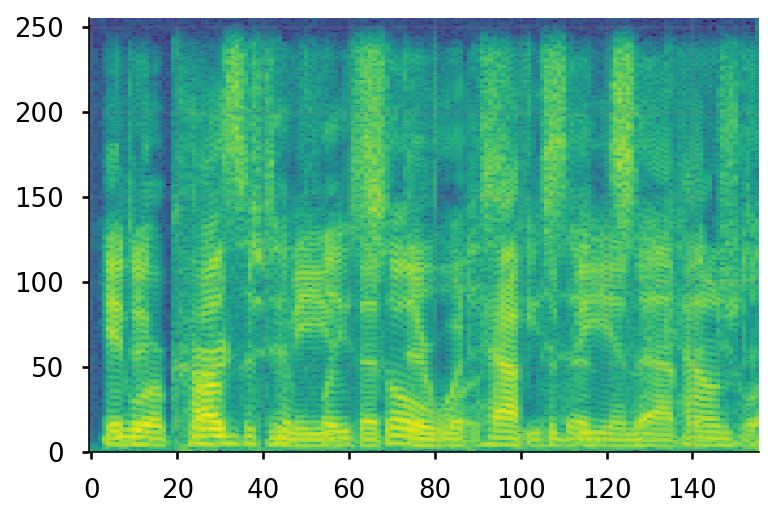

In [66]:
# Listen to the simulated received signal
t, ss = istft(np.real(source_stft_multichannel[:, 0, :]), fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(received_stft_multichannel[:, 0, :])), origin='lower', aspect='auto')
input_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel)
print("Input SINR: {:.2f} dB".format(input_sinr))
Audio(np.real(ss), rate=sampling_frequency, autoplay=True)

### Beamformers and outputs

FFT bin: 100%|██████████| 256/256 [00:00<00:00, 26780.61it/s]

Null controlling Batch DL output SINR: 37.04 dB


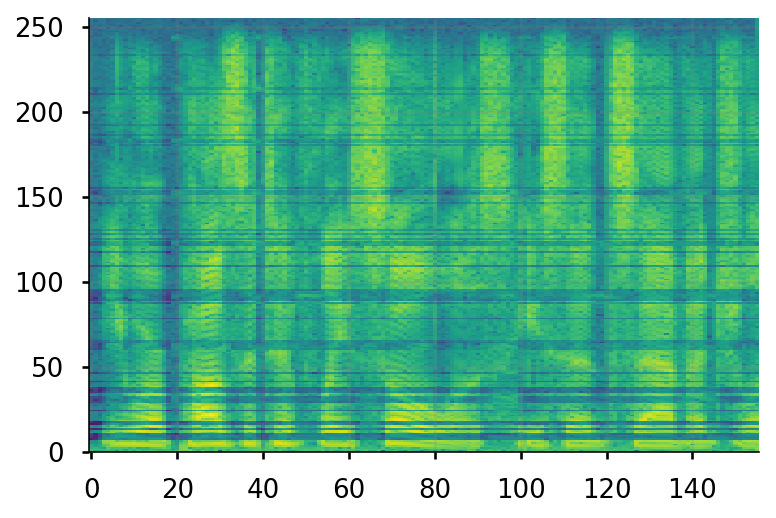

In [64]:
source_angle_index = 0
nc_dl_tf_batch_beamformers = dlbatchbeamformer.choose_weights(source_angle_index, 
                            interference_stfts_multichannel)
nc_dl_tf_batch_out = np.zeros((n_fft_bins, interference_stfts_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    nc_dl_tf_batch_out[i_fft_bin] = nc_dl_tf_batch_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, nc_dl_batch_out = istft(nc_dl_tf_batch_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(nc_dl_tf_batch_out)), origin='lower', aspect='auto')
nc_dl_batch_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, nc_dl_tf_batch_beamformers)
print("Null controlling Batch DL output SINR: {:.2f} dB".format(nc_dl_batch_out_sinr[0][0]))
Audio(np.real(nc_dl_batch_out), rate=sampling_frequency, autoplay=True)


### Beam pattern

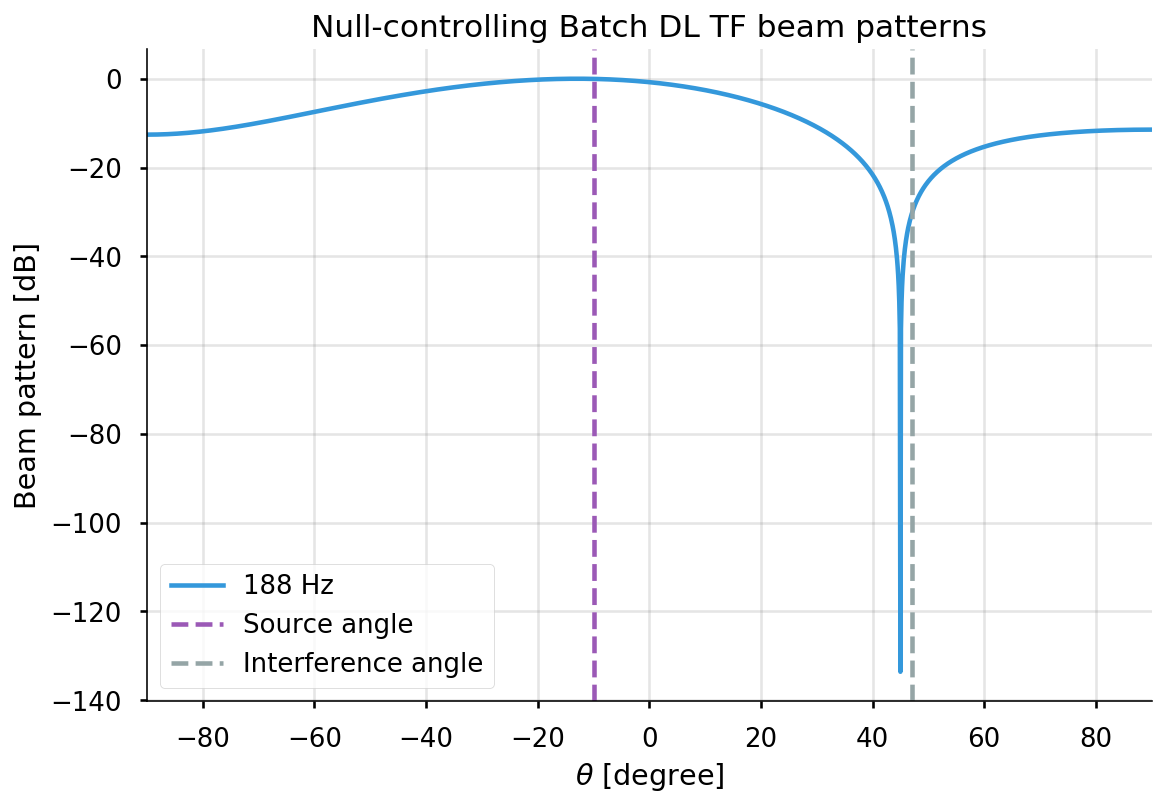

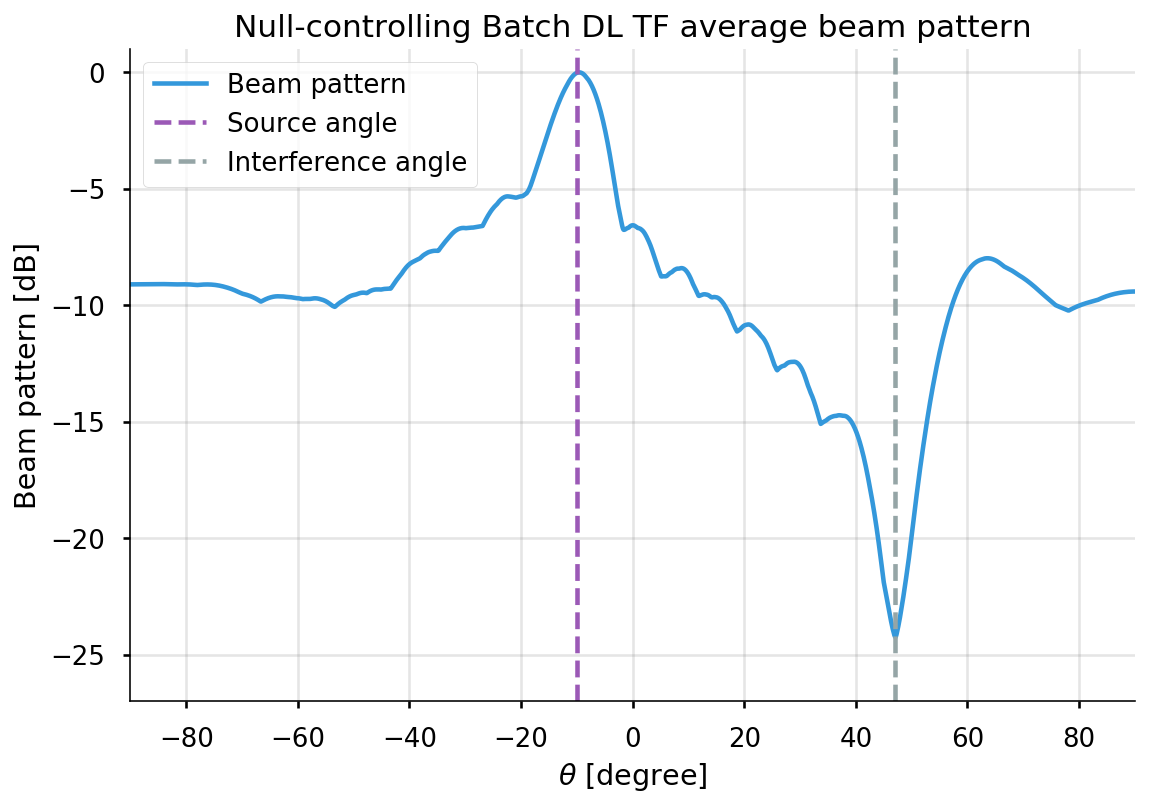

In [34]:
# Null-controlling DL beam pattern
nc_dl_tf_batch_beampattern = np.zeros((n_fft_bins, len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    for i_theta in range(len(theta_grid)):
        for i_phi in range(len(phi_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_theta][i_phi]
            nc_dl_tf_batch_beampattern[i_fft_bin][i_theta][i_phi] = nc_dl_tf_batch_beamformers[i_fft_bin].transpose().conjugate().dot(
            scanning_steering_vector)

nc_dl_tf_batch_beampattern_db = 20*np.log10(np.abs(nc_dl_tf_batch_beampattern));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
i_frequencies = [3]
for i_f in i_frequencies:
    ax.plot(theta_grid, nc_dl_tf_batch_beampattern_db[i_f, :, 0], label="{:.0f} Hz".format(i_f/n_fft_bins*sampling_frequency));
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Null-controlling Batch DL TF beam patterns")
ax.legend();

max_f_index = 32
nc_dl_ave_batch_beampattern = np.mean(np.abs(nc_dl_tf_batch_beampattern[0:max_f_index, :, 0]), axis=0)
nc_dl_ave_batch_beampattern_normalized = nc_dl_ave_batch_beampattern / np.max(nc_dl_ave_batch_beampattern)
nc_ave_batch_beampattern_normalized = nc_dl_ave_batch_beampattern
nc_dl_ave_batch_beampattern_normalized_db = 20*np.log10(nc_dl_ave_batch_beampattern_normalized)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, nc_dl_ave_batch_beampattern_normalized_db, label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90); ax.set_ylim(-27, 1)
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Null-controlling Batch DL TF average beam pattern")
ax.legend();

In [13]:
nc_dl_ave_batch_beampattern_normalized_db.shape

(1801,)